---

**Initial Data Analysis**

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

*Let's begin by setting up PySpark and loading the data*

In [1]:
!rm -f spark-3.5.1-bin-hadoop3.tgz

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df_weather = spark.read.csv("weather_csci4521_hw4.csv", header = True)

df_weather.show()

+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+---------+---------+-------------------+----------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+----------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------

*Let's get familiarized with the dataset*

In [6]:
from pyspark.sql import DataFrame

def print_df_summary(df: DataFrame) -> None:
    num_samples = df.count()
    num_features = len(df.columns)
    print(f"Number of samples: {num_samples}")
    print(f"Number of features: {num_features-1}") # last column is label

    df.describe().show()

print_df_summary(df_weather)

Number of samples: 96453
Number of features: 108
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------

---

**Data Cleaning and Pre-Processing**

**Data currently is in the format of strings, need to change appropriate features to doubles.**

In [7]:
import pyspark.sql.functions as F

excluded_columns = ['Formatted Date', 'Daily Summary']

columns_to_cast = [col for col in df_weather.columns if col not in excluded_columns]

for col_name in columns_to_cast:
    df_weather = df_weather.withColumn(col_name, F.col(col_name).cast('double'))

**Check: Unique Values per Feature**

---




In [8]:
import pyspark.sql.functions as F

df_weather.agg(*(F.countDistinct(F.col(c)).alias(c + ' Unique') for c in df_weather.columns)).show()

+---------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------------

*Without any knowledge on what the features are, this doesn't give us much. What is important to note is that there are 214 different distinctions for the daily weather summary.*

**Handling NULL/NaN Values**

In [9]:
import pyspark.sql.functions as F

# count the number of rows in each column that have NULL values
df_weather.agg(*(F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_weather.columns)).show()

+--------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

*Without knowledge on the features, we will fill up missing values with column medians. It is helpful to see that there are no missing values for the 'Daily Summary' feature. It is also nice to see that there is not a particular feature that has a ridiculous number of missing values.*

In [10]:
from pyspark.sql import functions as F

# calculate the medians of the feature columns that have missing values
feature_columns = [col for col in df_weather.columns if col not in ["Formatted Date", "Daily Summary", "Temperature (C)"]]
col_medians = {col: median for col, median in
               zip(feature_columns, list(df_weather.agg(*(F.expr(f'percentile_approx({col}, 0.5)').alias(col + '_median') for col in feature_columns)).collect()[0]))}

# fill the missing values with the medians
df_weather = df_weather.fillna(col_medians)

# check and make sure it worked
df_weather.agg(*(F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_weather.columns)).show()


+--------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

**Check: Duplicate Values**

In [11]:
# drop duplicate values
df_weather = df_weather.dropDuplicates()

# check how many samples and features we have afterwards
print_df_summary(df_weather)

Number of samples: 96212
Number of features: 108
+-------+--------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+----------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+----------

*It appears that there were about 241 duplicate samples that have now been removed from the dataset.*

**Standardize Features**

In [12]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.functions import vector_to_array
from pyspark.sql import functions as F
from pyspark.sql.functions import col

# define the columns to exclude from scaling
exclude_cols = ['Daily Summary', 'Formatted Date', 'Temperature (C)']

# save the 'Temperature' feature to not be included in standardization
df_weather_temp = df_weather.withColumn('index', F.monotonically_increasing_id())
df_weather_temp = df_weather_temp.select('Temperature (C)', 'index')

# save the categorical columns
df_weather_cat = df_weather.withColumn('index', F.monotonically_increasing_id())
df_weather_cat = df_weather_cat.select(['Formatted Date', 'Daily Summary', 'index'])

# select only the feature columns to standardize, excluding columns in `exclude_cols`
df_weather_stand = df_weather.withColumn('index', F.monotonically_increasing_id())
df_weather_stand = df_weather_stand.select([col for col in df_weather_stand.columns if col not in exclude_cols])

# create the dense vector
assembler = VectorAssembler(inputCols=df_weather_stand.columns, outputCol="vec_feats")
data_vec = assembler.transform(df_weather_stand)

# standardize the features
scaler = StandardScaler(inputCol="vec_feats", outputCol="features")
scaler_model = scaler.fit(data_vec)
scaled_data = scaler_model.transform(data_vec)

# convert the dense vector into an array
weather_df = scaled_data.withColumn("scaled_features", vector_to_array("features"))

# unpack the array into separate columns for each scaled feature
for i, feature in enumerate([col for col in df_weather_stand.columns if col != 'index']):
    weather_df = weather_df.withColumn(feature + "_scaled", col("scaled_features")[i])

# drop the original vector column, array column, and unscaled columns
weather_df = weather_df.drop("scaled_features")

# data after scaling
print("Data after scaling:")

# add back the features removed before scaling
weather_df = weather_df.join(df_weather_temp, on='index', how = 'inner')
weather_df = weather_df.join(df_weather_cat, on='index', how = 'inner')

# get the list of all columns
all_columns = weather_df.columns

# identify columns that match the pattern `feature_*_scaled`
scaled_columns = [col for col in all_columns if col.startswith("feature_") and col.endswith("_scaled")]

# keep only the scaled columns and other specific columns you might want to retain (like categorical columns)
columns_to_keep = scaled_columns + ['Formatted Date', 'Daily Summary', 'Temperature (C)', 'index']

# select only the desired columns
weather_df = weather_df.select(columns_to_keep)

# view the data
weather_df.show(10)

Data after scaling:
+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-----------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+----------------

*We have now standardized all of the numerical features.*

**Encoding and Scaling Categorical Variables**

*Let's attempt to unpack the 'Formatted Date' into specific year, month, day, hour, and minute. Following that, let's label encode our 'Daily Summary' feature so that each specific summary gets it's own value.*

In [13]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute

# convert to datetime format
weather_df = weather_df.withColumn("Formatted Date", weather_df['Formatted Date'].cast('timestamp'))

weather_df = weather_df.withColumn("Year", year(weather_df["Formatted Date"]))
weather_df = weather_df.withColumn("Month", month(weather_df["Formatted Date"]))
weather_df = weather_df.withColumn("Day", dayofmonth(weather_df["Formatted Date"]))
weather_df = weather_df.withColumn("Hour", hour(weather_df["Formatted Date"]))
weather_df = weather_df.withColumn("Minute", minute(weather_df["Formatted Date"]))

In [14]:
#  use label encoding for the 'Daily Summary'
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = "Daily Summary", outputCol = "Daily Summary Index")
indexer_model = indexer.fit(weather_df)
weather_df = indexer_model.transform(weather_df)

weather_df.show(truncate = False)

+-------------------+--------------------+---------------------+--------------------+--------------------+---------------------+--------------------+-----------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-----------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+---------------------+---------------------+----------------------+--------------------+-------------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------

In [15]:
# drop the original columns from before encoding
weather_df = weather_df.drop("Formatted Date", "Daily Summary")

**Feature Selection**

*Let's attempt to use ANOVA to select a subset of our current features.*

In [16]:
# convert to Pandas
weather_df_pandas = weather_df.toPandas()
weather_df_pandas.drop("index", axis = 1)

,feature_0_scaled,feature_1_scaled,feature_2_scaled,feature_3_scaled,feature_4_scaled,feature_5_scaled,feature_6_scaled,feature_7_scaled,feature_8_scaled,feature_9_scaled,...,feature_103_scaled,feature_104_scaled,feature_105_scaled,Temperature (C),Year,Month,Day,Hour,Minute,Daily Summary Index
0,1.198739,0.891553,-0.168521,1.141597,1.047094,0.442002,1.734764,8.729771,3.854597,-0.801131,...,0.130992,0.036905,2.532500,7.855556,2006,4,12,21,0,131.0
1,-0.792997,1.304682,-0.049000,-1.334160,-1.564383,0.985136,-0.052481,8.804271,4.443494,-1.012029,...,1.394789,-0.150961,1.988717,22.450000,2006,8,18,21,0,21.0
2,0.791822,2.027356,0.702287,-0.270669,-0.965971,-0.007638,0.546263,8.814418,4.818247,-1.329429,...,-0.542166,-1.149143,-0.336887,13.855556,2006,8,23,23,0,3.0
3,2.144078,-0.173349,-0.402444,1.011557,0.579989,1.828532,1.465644,8.701757,3.426309,0.108502,...,0.048252,0.077202,2.104860,24.883333,2006,8,3,15,0,0.0
4,1.849303,0.385875,2.698407,-0.087478,-0.757991,1.739560,1.167229,8.725348,4.925319,0.566722,...,0.046662,-0.264166,0.543236,19.022222,2006,8,4,15,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96207,1.477731,1.133846,-0.306474,-0.446104,-1.913883,0.769191,1.031754,8.808954,5.139463,1.003717,...,1.330850,0.033127,-0.404711,7.800000,2016,10,6,17,0,8.0
96208,1.324370,1.248241,-0.033823,-1.117686,0.516551,-1.397325,1.361805,8.859604,4.978855,1.893695,...,-0.972431,-0.795068,1.580082,2.244444,2016,10,9,4,0,2.0
96209,-0.065035,2.101686,2.202382,1.355831,-2.204105,1.415360,0.034138,8.833672,1.766690,0.191612,...,1.592592,-0.533212,2.705441,31.038889,2016,9,12,11,0,1.0
96210,0.983593,-0.597320,1.123082,1.554119,-0.579335,-1.163058,-0.966914,8.913549,4.497030,0.773713,...,1.723393,-1.177951,0.747397,9.883333,2016,9,27,20,0,6.0


In [17]:
# helper function from class
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import matplotlib.pyplot as plt

def select_features(
    X: np.ndarray,
    y: np.ndarray,
    num_features: int,
    score_func: str
) -> tuple[np.ndarray, sklearn.feature_selection._univariate_selection.SelectKBest]:

    if score_func == "chi2":
        # measure whether feature is independent of label (and therefore not useful)
        # compares frequency of feature value to expected value using labels
        fs = SelectKBest(score_func = chi2, k = num_features )
    elif score_func == "anova":
        # measure means between features and labels
        fs = SelectKBest(score_func = f_classif, k = num_features )
    else:
        raise ValueError(f"Unknown score function: {score_func}. Available functions: chi2, anova.")
    fs.fit(X, y)
    X_fs = fs.transform(X)
    return X_fs, fs

Before feature selection:
Num samples: 96212
Num features: 113



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 17 111] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


After feature selection:
Num samples: 96212
Num features: 10

Anova feature scores:
Feature 0: 0.9746370941870047
Feature 1: 1.0221168629244164
Feature 2: 0.9920271120098137
Feature 3: 1.0003279911334395
Feature 4: 0.9764488178040261
Feature 5: 1.0137427724809995
Feature 6: 1.0263171122034354
Feature 7: 1.853458552676928
Feature 8: 11.691361041846646
Feature 9: 1.0175258409509296
Feature 10: 1.0385640758496253
Feature 11: 1.0010863981869529
Feature 12: 1.0138624992032077
Feature 13: 1.016489397075515
Feature 14: 0.9987969698146939
Feature 15: 0.9755798816160958
Feature 16: 1.002743678097347
Feature 17: nan
Feature 18: 1.0256798405236096
Feature 19: 4.860319374590145
Feature 20: 1.0115605616047294
Feature 21: 1.0097229189127968
Feature 22: 0.9820604039224344
Feature 23: 1.0308598289593525
Feature 24: 0.9988920021393191
Feature 25: 0.9802462543846283
Feature 26: 1.009429295319596
Feature 27: 0.9989192338835622
Feature 28: 1.0253545726889666
Feature 29: 1.0053219660619126
Feature 30: 0.94

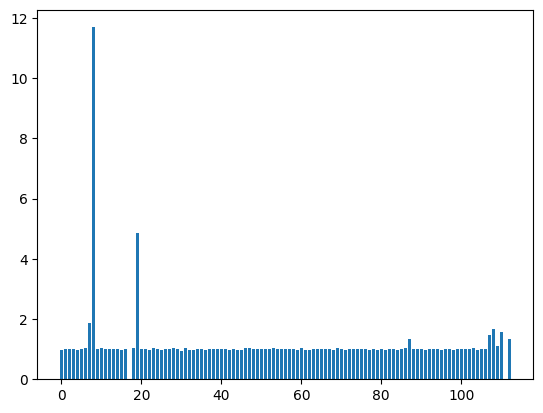

In [18]:
# prepare input data
# weather_df_pandas = weather_df_pandas.drop("index", axis = 1)
y = weather_df_pandas["Temperature (C)"]
X = weather_df_pandas.drop("Temperature (C)", axis = 1)


# get the number of samples and features from our data
num_samples, num_features = X.shape

print("Before feature selection:")
print(f"Num samples: {num_samples}")
print(f"Num features: {num_features}")
print("")

# pick arbitrary value
num_features_to_select = 10

# select features
X_feat, fs = select_features(X, y, num_features_to_select, "anova")

# get new data metrics
num_samples, num_features = X_feat.shape

print("After feature selection:")
print(f"Num samples: {num_samples}")
print(f"Num features: {num_features}")
print("")

# what are scores for the features
print("Anova feature scores:")
for i in range(len(fs.scores_)):
    print(f"Feature {i}: {fs.scores_[i]}")

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

*It looks like we have about 10 features that have a higher ANOVA score than the rest of the features. Let's get the top 10 and move onto building the models.*

In [19]:
# get the 10 best features based on scores
top_feats = np.argsort(fs.scores_)[-10:]
print("Selected top features:")
print([X.columns[i] for i in top_feats])

# put the data back into PySpark
# recombine `X` and `y` for the final data frame
weather_df_pandas["Temperature (C)"] = y

weather_spark = spark.createDataFrame(weather_df_pandas)

# select the columns
top_features = ["Daily Summary Index", "feature_87_scaled", "Year", "Hour", "Month", "feature_7_scaled", "feature_19_scaled", "feature_8_scaled", "feature_17_scaled", "Minute"]

# create the final data frame with selected features and the target column
weather_model_df = weather_spark.select(top_features + ["Temperature (C)"])

weather_model_df.show()

Selected top features:
['Daily Summary Index', 'feature_87_scaled', 'Year', 'Hour', 'Month', 'feature_7_scaled', 'feature_19_scaled', 'feature_8_scaled', 'feature_17_scaled', 'Minute']
+-------------------+-------------------+----+----+-----+-----------------+-------------------+------------------+-----------------+------+-------------------+
|Daily Summary Index|  feature_87_scaled|Year|Hour|Month| feature_7_scaled|  feature_19_scaled|  feature_8_scaled|feature_17_scaled|Minute|    Temperature (C)|
+-------------------+-------------------+----+----+-----+-----------------+-------------------+------------------+-----------------+------+-------------------+
|              131.0| 1.4373432377712465|2006|  21|    4| 8.72977086472013| 3.5897390501841056| 3.854597448025842|              0.0|     0|  7.855555555555556|
|               21.0|  0.514516955392663|2006|  21|    8|8.804270876371643|  3.578184096159907| 4.443494280363123|              0.0|     0|              22.45|
|              

**Modeling**

**Lasso Regression**

In [20]:
# bring our data back to pandas
weather_model_df = weather_model_df.toPandas()

In [21]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

# prepare input data
X = weather_model_df.drop("Temperature (C)", axis = 1)
y = weather_model_df["Temperature (C)"]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# store mse's
lasso_train_rmse = []
lasso_test_rmse = []
lasso_cv_rmse = []
lasso_cv_stddev = []

# define hyperparameters
lambda_vals = [1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3]

for lambda_val in lambda_vals:
    lasso_model = Lasso(alpha = lambda_val)

    lasso_scores = cross_val_score(lasso_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

    lasso_model.fit(X_train, y_train)

    train_preds = lasso_model.predict(X_train)
    test_preds = lasso_model.predict(X_test)

    lasso_train_rmse.append(root_mean_squared_error(y_train, train_preds))
    lasso_test_rmse.append(root_mean_squared_error(y_test, test_preds))
    lasso_cv_rmse.append(-lasso_scores.mean())
    lasso_cv_stddev.append(lasso_scores.std())

    print("Lambda: ", lambda_val)
    print("Train RMSE: ", root_mean_squared_error(y_train, train_preds))
    print("Test RMSE: ", root_mean_squared_error(y_test, test_preds))
    print("Train R^2: ", r2_score(y_train, train_preds))
    print("Test R^2: ", r2_score(y_test, test_preds))
    print(f"Average Cross Validated RMSE: {-lasso_scores.mean()}")
    print(f"Average Cross Validated STDDEV: {lasso_scores.std()}")
    print("")

Lambda:  0.001
Train RMSE:  7.042469824595721
Test RMSE:  7.039607179788137
Train R^2:  0.45586586690931874
Test R^2:  0.4575966620425168
Average Cross Validated RMSE: 7.043229204575712
Average Cross Validated STDDEV: 0.03852288855356684

Lambda:  0.01
Train RMSE:  7.042502605409837
Test RMSE:  7.039760372065853
Train R^2:  0.4558608012997163
Test R^2:  0.45757305478581556
Average Cross Validated RMSE: 7.043262165300564
Average Cross Validated STDDEV: 0.038438393383887444

Lambda:  0.1
Train RMSE:  7.045779988001705
Test RMSE:  7.0442182583847055
Train R^2:  0.4553542293044124
Test R^2:  0.45688586001018605
Average Cross Validated RMSE: 7.046533134504777
Average Cross Validated STDDEV: 0.037680292090740954

Lambda:  1
Train RMSE:  7.198602611066441
Test RMSE:  7.201371986363709
Train R^2:  0.43147131832131
Test R^2:  0.4323822180288568
Average Cross Validated RMSE: 7.199135645220489
Average Cross Validated STDDEV: 0.03602739227347445

Lambda:  10
Train RMSE:  9.464738514500702
Test RMS

In [22]:
# take the best lambda
best_lam_idx = np.argmin(lasso_cv_rmse)
lasso_lambda = lambda_vals[best_lam_idx]

# retrain the final model with the best lambda
final_lasso_model = Lasso(alpha = lasso_lambda)
final_lasso_model.fit(X_train, y_train)

# cross validation
lasso_scores = cross_val_score(final_lasso_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

# make final predictions
lasso_train_preds = final_lasso_model.predict(X_train)
lasso_test_preds = final_lasso_model.predict(X_test)

# final evaluation
print(f"Best Lambda: {lasso_lambda}")
print("Final Train RMSE: ", root_mean_squared_error(y_train, lasso_train_preds))
print("Final Test RMSE: ", root_mean_squared_error(y_test, lasso_test_preds))
print("Final Train R^2: ", r2_score(y_train, lasso_train_preds))
print("Final Test R^2: ", r2_score(y_test, lasso_test_preds))
print("Final Test Average Cross Validated Score: ", -lasso_scores.mean())
print("Final Test Average Cross Validated STDDEV: ", lasso_scores.std())

Best Lambda: 0.001
Final Train RMSE:  7.042469824595721
Final Test RMSE:  7.039607179788137
Final Train R^2:  0.45586586690931874
Final Test R^2:  0.4575966620425168
Final Test Average Cross Validated Score:  -7.043229204575712
Final Test Average Cross Validated STDDEV:  0.03852288855356684


**Ridge Regression**

In [23]:
from sklearn.linear_model import Ridge

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# define lambdas
lambda_vals = [1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3]

# store results
ridge_train_rmse = []
ridge_test_rmse = []
ridge_cv_rmse = []
ridge_cv_stddev = []

for lambda_val in lambda_vals:

    # initialize model
    ridge_model = Ridge(alpha = lambda_val)

    ridge_scores = cross_val_score(ridge_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

    # fit the model
    ridge_model.fit(X_train, y_train)

    # make predictions
    ridge_train_preds = ridge_model.predict(X_train)
    ridge_test_preds = ridge_model.predict(X_test)

    ridge_train_rmse.append(root_mean_squared_error(y_train, ridge_train_preds))
    ridge_test_rmse.append(root_mean_squared_error(y_test, ridge_test_preds))
    ridge_cv_rmse.append(-ridge_scores.mean())
    ridge_cv_stddev.append(ridge_scores.std())

    print("Lambda: ", lambda_val)
    print("Train RMSE: ", root_mean_squared_error(y_train, ridge_train_preds))
    print("Test RMSE: ", root_mean_squared_error(y_test, ridge_test_preds))
    print("Train R^2: ", ridge_model.score(X_train, y_train))
    print("Test R^2: ", ridge_model.score(X_test, y_test))
    print(f"Average Cross Validated RMSE: {-ridge_scores.mean()}")
    print(f"Average Cross Validated STDDEV: {ridge_scores.std()}")
    print("")

Lambda:  0.001
Train RMSE:  7.042469493471123
Test RMSE:  7.039593443931019
Train R^2:  0.45586591807778554
Test R^2:  0.45759877874229615
Average Cross Validated RMSE: 7.043228857090767
Average Cross Validated STDDEV: 0.03853238372713095

Lambda:  0.01
Train RMSE:  7.0424694934711685
Test RMSE:  7.039593444607453
Train R^2:  0.45586591807777854
Test R^2:  0.45759877863805765
Average Cross Validated RMSE: 7.043228857069556
Average Cross Validated STDDEV: 0.038532382061297304

Lambda:  0.1
Train RMSE:  7.042469493475678
Test RMSE:  7.039593451375853
Train R^2:  0.45586591807708177
Test R^2:  0.45759877759504597
Average Cross Validated RMSE: 7.043228856863803
Average Cross Validated STDDEV: 0.03853236540303482

Lambda:  1
Train RMSE:  7.042469493926642
Test RMSE:  7.039593519466262
Train R^2:  0.4558659180073945
Test R^2:  0.4575987671023034
Average Cross Validated RMSE: 7.043228855440544
Average Cross Validated STDDEV: 0.038532198827684355

Lambda:  10
Train RMSE:  7.042469539009889
Tes

In [24]:
# take the best lambda
best_lam_idx2 = np.argmin(ridge_cv_rmse)
ridge_lambda = lambda_vals[best_lam_idx2]

# retrain the final model with the best lambda
final_ridge_model = Ridge(alpha = ridge_lambda)
final_ridge_model.fit(X_train, y_train)

# cross validation
ridge_scores = cross_val_score(final_ridge_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

# make final predictions
ridge_train_preds = final_ridge_model.predict(X_train)
ridge_test_preds = final_ridge_model.predict(X_test)

# final evaluation
print(f"Best Lambda: {ridge_lambda}")
print("Final Train RMSE: ", root_mean_squared_error(y_train, ridge_train_preds))
print("Final Test RMSE: ", root_mean_squared_error(y_test, ridge_test_preds))
print("Final Train R^2: ", r2_score(y_train, ridge_train_preds))
print("Final Test R^2: ", r2_score(y_test, ridge_test_preds))
print("Final Test Average Cross Validated Score: ", -ridge_scores.mean())
print("Final Test Average Cross Validated STDDEV: ", ridge_scores.std())

Best Lambda: 1
Final Train RMSE:  7.042469493926642
Final Test RMSE:  7.039593519466262
Final Train R^2:  0.4558659180073945
Final Test R^2:  0.4575987671023034
Final Test Average Cross Validated Score:  -7.043228855440544
Final Test Average Cross Validated STDDEV:  0.038532198827684355


**Linear Regression**

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# initialize model
lsq_model = LinearRegression()

# 5-fold cross validation
lr_scores = cross_val_score(lsq_model, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')

# fit the model
lsq_model.fit(X_train, y_train)

# make predictions
lsq_test_preds_train_preds = lsq_model.predict(X_train)
lsq_test_preds = lsq_model.predict(X_test)

# get the average and standard deviation of the scores
lr_avg_score = lr_scores.mean()
lr_std_score = lr_scores.std()

# print results
print("Linear Regression")
print("Train RMSE: ", root_mean_squared_error(y_train, lsq_test_preds_train_preds))
print("Test RMSE: ", root_mean_squared_error(y_test, lsq_test_preds))
print("R^2 Train: ", lsq_model.score(X_train, y_train))
print("R^2 Test: ", lsq_model.score(X_test, y_test))
print(f"Average Cross Validated RMSE: {-lr_scores.mean()}")
print(f"Average Cross Validated STDDEV: {lr_scores.std()}")
print("")

Linear Regression
Train RMSE:  7.042469493471122
Test RMSE:  7.039593443855865
R^2 Train:  0.45586591807778565
R^2 Test:  0.45759877875387744
Average Cross Validated RMSE: 7.046583352100605
Average Cross Validated STDDEV: 0.03642290081908291



**KNN Regression**

In [26]:
from sklearn.neighbors import KNeighborsRegressor

# choose 5 neighbors
n_neighbors = 5

for i, weights in enumerate(["uniform", "distance"]):  # weights are the hyperparameter, test both uniform and distance

  # initialize the model
  knn = KNeighborsRegressor(n_neighbors, weights = weights)

  # perform 5-fold cross-validation
  knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

  # fit the model and make predictions
  knn.fit(X_train, y_train)
  knn_train_preds = knn.predict(X_train)
  knn_test_preds = knn.predict(X_test)

  # evaluate the model
  knn_train_rmse = root_mean_squared_error(y_train, knn_train_preds)
  knn_test_rmse = root_mean_squared_error(y_test, knn_test_preds)
  knn_train_r2 = r2_score(y_train, knn_train_preds)
  knn_test_r2 = r2_score(y_test, knn_test_preds)
  knn_avg_cv_score = -knn_cv_scores.mean()
  knn_std_cv_score = knn_cv_scores.std()

  print(f"KNN Regression: {[i]}")
  print(f"Train RMSE: {knn_train_rmse}")
  print(f"Test RMSE: {knn_test_rmse}")
  print(f"Train R^2: {knn_train_r2}")
  print(f"Test R^2: {knn_test_r2}")
  print(f"Average Cross-Validated MSE: {knn_avg_cv_score}")
  print(f"Average Cross-Validated STDDEV: {knn_std_cv_score}")
  print("")

KNN Regression: [0]
Train RMSE: 2.742680635062054
Test RMSE: 3.450925628603249
Train R^2: 0.9174710232623949
Test R^2: 0.8696543019859183
Average Cross-Validated MSE: 13.165952594335826
Average Cross-Validated STDDEV: 0.22743263314104228

KNN Regression: [1]
Train RMSE: 0.00016086439472995322
Test RMSE: 3.360113805849265
Train R^2: 0.9999999997160932
Test R^2: 0.8764241869639904
Average Cross-Validated MSE: 12.366441654625124
Average Cross-Validated STDDEV: 0.20852275351418625



In [27]:
# distance performed better

# retrain the final model with the best weight hyperparameter
final_knn_model = KNeighborsRegressor(n_neighbors = 5, weights = "distance")
final_knn_model.fit(X_train, y_train)

# cross validation
knn_cv_scores = cross_val_score(final_knn_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

# make final predictions
knn_train_preds = final_knn_model.predict(X_train)
knn_test_preds = final_knn_model.predict(X_test)

# final evaluation
print("Best Weight Hyperparameter: Distance")
print("Final Train RMSE: ", root_mean_squared_error(y_train, knn_train_preds))
print("Final Test RMSE: ", root_mean_squared_error(y_test, knn_test_preds))
print("Final Train R^2: ", r2_score(y_train, knn_train_preds))
print("Final Test R^2: ", r2_score(y_test, knn_test_preds))
print("Final Test Average Cross Validated Score: ", knn_cv_scores.mean())
print("Final Test Average Cross Validated STDDEV: ", knn_cv_scores.std())

Best Weight Hyperparameter: Distance
Final Train RMSE:  0.00016086439472995322
Final Test RMSE:  3.360113805849265
Final Train R^2:  0.9999999997160932
Final Test R^2:  0.8764241869639904
Final Test Average Cross Validated Score:  -3.516470947278131
Final Test Average Cross Validated STDDEV:  0.02955895082654566


**Support Vector Regression**

*Skipping due to computation time.*

**Decision Tree Regressor**

In [28]:
from sklearn.tree import DecisionTreeRegressor

# define max_depth hyperparameter choices
max_depth_choices = [2, 4, 6, 8, 10]

# store results
dt_train_rmse = []
dt_test_rmse = []
dt_cv_rmse = []
dt_cv_stddev = []

for depth in max_depth_choices:

  # define the decision tree regression model
  dtr = DecisionTreeRegressor(max_depth = depth, random_state=0)

  # perform 5-fold cross-validation
  dtr_cv_scores = cross_val_score(dtr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

  # fit the model and make predictions
  dtr.fit(X_train, y_train)
  dtr_train_preds = dtr.predict(X_train)
  dtr_test_preds = dtr.predict(X_test)

  # evaluate the model
  dt_train_rmse.append(root_mean_squared_error(y_train, dtr_train_preds))
  dt_test_rmse.append(root_mean_squared_error(y_test, dtr_test_preds))
  dt_cv_rmse.append(-dtr_cv_scores.mean())
  dt_cv_stddev.append(dtr_cv_scores.std())

  print("Decision Tree Regression")
  print(f"Train RMSE: {root_mean_squared_error(y_train, dtr_train_preds)}")
  print(f"Test RMSE: {root_mean_squared_error(y_test, dtr_test_preds)}")
  print(f"Train R^2: {dtr.score(X_train, y_train)}")
  print(f"Test R^2: {dtr.score(X_test, y_test)}")
  print(f"Average Cross-Validated MSE: {-dtr_cv_scores.mean()}")
  print(f"Average Cross-Validated STDDEV: {dtr_cv_scores.std()}")
  print("")

Decision Tree Regression
Train RMSE: 6.819030964957189
Test RMSE: 6.80760421073789
Train R^2: 0.48984598941948476
Test R^2: 0.49275929338232183
Average Cross-Validated MSE: 46.533056292657825
Average Cross-Validated STDDEV: 0.6362293185158099

Decision Tree Regression
Train RMSE: 4.702105362360922
Test RMSE: 4.722163415198299
Train R^2: 0.7574279867009233
Test R^2: 0.7559338633004935
Average Cross-Validated MSE: 22.163109403245972
Average Cross-Validated STDDEV: 0.3447112911122836

Decision Tree Regression
Train RMSE: 4.1184701012794624
Test RMSE: 4.193010020727195
Train R^2: 0.8139079521603552
Test R^2: 0.807567995838121
Average Cross-Validated MSE: 17.234806054404547
Average Cross-Validated STDDEV: 0.2878632047405651

Decision Tree Regression
Train RMSE: 3.6868984137049874
Test RMSE: 3.7590429553230957
Train R^2: 0.8508654311106146
Test R^2: 0.8453392615600687
Average Cross-Validated MSE: 14.149796109558128
Average Cross-Validated STDDEV: 0.3456304180956987

Decision Tree Regression


In [29]:
# take the best depth
best_depth = np.argmin(dt_cv_rmse)
dt_depth = max_depth_choices[best_depth]

# retrain the final model with the best lambda
final_dt_model = DecisionTreeRegressor(max_depth = dt_depth, random_state=0)
final_dt_model.fit(X_train, y_train)

# cross validation
dtr_cv_scores = cross_val_score(final_dt_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

# make final predictions
dt_train_preds = final_dt_model.predict(X_train)
dt_test_preds = final_dt_model.predict(X_test)

# final evaluation
print(f"Best Max Depth: {dt_depth}")
print("Final Train RMSE: ", root_mean_squared_error(y_train, dt_train_preds))
print("Final Test RMSE: ", root_mean_squared_error(y_test, dt_test_preds))
print("Final Train R^2: ", r2_score(y_train, dt_train_preds))
print("Final Test R^2: ", r2_score(y_test, dt_test_preds))
print("Final Test Average Cross Validated Score: ", -dtr_cv_scores.mean())
print("Final Test Average Cross Validated STDDEV: ", dtr_cv_scores.std())

Best Max Depth: 10
Final Train RMSE:  3.2958292145239168
Final Test RMSE:  3.509211767688462
Final Train R^2:  0.8808249402938113
Final Test R^2:  0.865214039915158
Final Test Average Cross Validated Score:  3.5066595268615934
Final Test Average Cross Validated STDDEV:  0.043272727635545065


**Bagging**

In [30]:
from sklearn.ensemble import BaggingRegressor

# define choices for n_estimators
n_estimators_choices = [10, 25, 50, 75, 100]

# store results
br_train_rmse = []
br_test_rmse = []
br_cv_rmse = []
br_cv_stddev = []

for estimator in n_estimators_choices:

  # define the bagging regression model
  br = BaggingRegressor(n_estimators= estimator, random_state=0)

  # perform 5-fold cross-validation
  br_cv_scores = cross_val_score(br, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

  # fit the model and make predictions
  br.fit(X_train, y_train)
  br_train_preds = br.predict(X_train)
  br_test_preds = br.predict(X_test)

  # evaluate the model
  br_train_rmse.append(root_mean_squared_error(y_train, br_train_preds))
  br_test_rmse.append(root_mean_squared_error(y_test, br_test_preds))
  br_cv_rmse.append(-br_cv_scores.mean())
  br_cv_stddev.append(br_cv_scores.std())

  print("Bagging Regression")
  print(f"Train RMSE: {root_mean_squared_error(y_train, br_train_preds)}")
  print(f"Test RMSE: {root_mean_squared_error(y_test, br_test_preds)}")
  print(f"Train R^2: {br.score(X_train, y_train)}")
  print(f"Test R^2: {br.score(X_test, y_test)}")
  print(f"Average Cross-Validated MSE: {-br_cv_scores.mean()}")
  print(f"Average Cross-Validated STDDEV: {br_cv_scores.std()}")
  print("")

Bagging Regression
Train RMSE: 1.1286649844332894
Test RMSE: 2.6294380398182917
Train R^2: 0.9860238972904034
Test R^2: 0.9243251819416639
Average Cross-Validated MSE: 7.429017768495193
Average Cross-Validated STDDEV: 0.13173385337981275

Bagging Regression
Train RMSE: 0.9967196048503378
Test RMSE: 2.5262677118912764
Train R^2: 0.989100615303737
Test R^2: 0.930147131475289
Average Cross-Validated MSE: 6.8656621642048306
Average Cross-Validated STDDEV: 0.12915096912652452

Bagging Regression
Train RMSE: 0.9475710684079105
Test RMSE: 2.483175454162179
Train R^2: 0.990149017115496
Test R^2: 0.9325098620690287
Average Cross-Validated MSE: 6.706997511715164
Average Cross-Validated STDDEV: 0.12155964474310751

Bagging Regression
Train RMSE: 0.9311278739024981
Test RMSE: 2.4663687851778793
Train R^2: 0.9904879388068277
Test R^2: 0.9334203461548918
Average Cross-Validated MSE: 6.632885618615228
Average Cross-Validated STDDEV: 0.12459106520274994

Bagging Regression
Train RMSE: 0.92274803881539

In [31]:
# take the best choice for estimators
br_best_estimator = np.argmin(br_cv_rmse)
br_estimator = n_estimators_choices[br_best_estimator]

# retrain the final model with the best lambda
final_br_model = BaggingRegressor(n_estimators = br_estimator , random_state=0)
final_br_model.fit(X_train, y_train)

# cross validation
br_cv_scores = cross_val_score(final_br_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

# make final predictions
br_train_preds = final_br_model.predict(X_train)
br_test_preds = final_br_model.predict(X_test)

# final evaluation
print(f"Best Estimator: {br_estimator}")
print("Final Train RMSE: ", root_mean_squared_error(y_train, br_train_preds))
print("Final Test RMSE: ", root_mean_squared_error(y_test, br_test_preds))
print("Final Train R^2: ", r2_score(y_train, br_train_preds))
print("Final Test R^2: ", r2_score(y_test, br_test_preds))
print("Final Test Average Cross Validated Score: ", -br_cv_scores.mean())
print("Final Test Average Cross Validated STDDEV: ", br_cv_scores.std())

Best Estimator: 100
Final Train RMSE:  0.9227480388153929
Final Test RMSE:  2.4598139579325338
Final Train R^2:  0.9906583790376677
Final Test R^2:  0.9337737711585101
Final Test Average Cross Validated Score:  2.5707905778683697
Final Test Average Cross Validated STDDEV:  0.023708819119051858


**Random Forest Regressor**

In [32]:
from sklearn.ensemble import RandomForestRegressor

# define number of trees hyperparameter
num_trees = [1, 25, 50, 75, 100]

# store results
rfr_train_rmse = []
rfr_test_rmse = []
rfr_cv_rmse = []
rfr_cv_stddev = []

for tree in num_trees:

  # define the random forest regression model
  rfr = RandomForestRegressor(n_estimators = tree, random_state=0)

  # perform 5-fold cross-validation
  rfr_cv_scores = cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

  # fit the model and make predictions
  rfr.fit(X_train, y_train)
  rfr_train_preds = rfr.predict(X_train)
  rfr_test_preds = rfr.predict(X_test)

  # evaluate the model
  rfr_train_rmse.append(root_mean_squared_error(y_train, rfr_train_preds))
  rfr_test_rmse.append(root_mean_squared_error(y_test, rfr_test_preds))
  rfr_cv_rmse.append(-rfr_cv_scores.mean())
  rfr_cv_stddev.append(rfr_cv_scores.std())

  print("Random Forest Regression")
  print(f"Train RMSE: {root_mean_squared_error(y_train, rfr_train_preds)}")
  print(f"Test RMSE: {root_mean_squared_error(y_test, rfr_test_preds)}")
  print(f"Train R^2: {rfr.score(X_train, y_train)}")
  print(f"Test R^2: {rfr.score(X_test, y_test)}")
  print(f"Average Cross-Validated MSE: {-rfr_cv_scores.mean()}")
  print(f"Average Cross-Validated STDDEV: {rfr_cv_scores.std()}")
  print("")

Random Forest Regression
Train RMSE: 2.38320903248934
Test RMSE: 3.9238387186572
Train R^2: 0.9376867715704867
Test R^2: 0.8314814168815193
Average Cross-Validated MSE: 16.018330077392516
Average Cross-Validated STDDEV: 0.2705924406044364

Random Forest Regression
Train RMSE: 0.9961501571438685
Test RMSE: 2.5270147802933085
Train R^2: 0.9891130658597317
Test R^2: 0.930105811557625
Average Cross-Validated MSE: 6.865193682454785
Average Cross-Validated STDDEV: 0.11973666867587561

Random Forest Regression
Train RMSE: 0.9475914074834706
Test RMSE: 2.4829795196060385
Train R^2: 0.9901485942194362
Test R^2: 0.9325205122455938
Average Cross-Validated MSE: 6.704837357988227
Average Cross-Validated STDDEV: 0.11547823536347546

Random Forest Regression
Train RMSE: 0.9311824150943583
Test RMSE: 2.4677687966124204
Train R^2: 0.9904868244285269
Test R^2: 0.9333447380521662
Average Cross-Validated MSE: 6.630472019020678
Average Cross-Validated STDDEV: 0.12007051937815212

Random Forest Regression
T

In [33]:
# take the best choice for number of trees
rfr_trees = np.argmin(br_cv_rmse)
rfr_best_tree = num_trees[rfr_trees]

# retrain the final model with the best lambda
final_rfr_model = RandomForestRegressor(n_estimators = rfr_best_tree , random_state=0)
final_rfr_model.fit(X_train, y_train)

# cross validation
rfr_cv_scores = cross_val_score(final_rfr_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

# make final predictions
rfr_train_preds = final_rfr_model.predict(X_train)
rfr_test_preds = final_rfr_model.predict(X_test)

# final evaluation
print(f"Best Number of Trees: {rfr_best_tree}")
print("Final Train RMSE: ", root_mean_squared_error(y_train, rfr_train_preds))
print("Final Test RMSE: ", root_mean_squared_error(y_test, rfr_test_preds))
print("Final Train R^2: ", r2_score(y_train, rfr_train_preds))
print("Final Test R^2: ", r2_score(y_test, rfr_test_preds))
print("Final Test Average Cross Validated Score: ", -rfr_cv_scores.mean())
print("Final Test Average Cross Validated STDDEV: ", rfr_cv_scores.std())

Best Number of Trees: 100
Final Train RMSE:  0.9228443525297069
Final Test RMSE:  2.461605377319172
Final Train R^2:  0.9906564288342966
Final Test R^2:  0.933677274307015
Final Test Average Cross Validated Score:  2.5700644294021564
Final Test Average Cross Validated STDDEV:  0.022799012937305255


**Adaboost Regression**

In [34]:
from sklearn.ensemble import AdaBoostRegressor

# define number of trees hyperparameter
adaboost_trees = [1, 25, 50, 75, 100]

# store results
abr_train_rmse = []
abr_test_rmse = []
abr_cv_rmse = []
abr_cv_stddev = []

rng = np.random.RandomState(1)

for trees in adaboost_trees:

  # define the adaboost regression model
  abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 10), n_estimators = trees, random_state = rng)

  # perform 5-fold cross-validation
  abr_cv_scores = cross_val_score(abr, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')

  # fit the model and make predictions
  abr.fit(X_train, y_train)
  abr_train_preds = abr.predict(X_train)
  abr_test_preds = abr.predict(X_test)

  # evaluate the model
  abr_train_rmse.append(root_mean_squared_error(y_train, abr_train_preds))
  abr_test_rmse.append(root_mean_squared_error(y_test, abr_test_preds))
  abr_cv_rmse.append(-abr_cv_scores.mean())
  abr_cv_stddev.append(abr_cv_scores.std())


  print("AdaBoost Regression")
  print(f"Train RMSE: {root_mean_squared_error(y_train, abr_train_preds)}")
  print(f"Test RMSE: {root_mean_squared_error(y_test, abr_test_preds)}")
  print(f"Train R^2: {abr.score(X_train, y_train)}")
  print(f"Test R^2: {abr.score(X_test, y_test)}")
  print(f"Average Cross-Validated MSE: {-abr_cv_scores.mean()}")
  print(f"Average Cross-Validated STDDEV: {abr_cv_scores.std()}")
  print("")

AdaBoost Regression
Train RMSE: 3.3855419746527837
Test RMSE: 3.567212908550218
Train R^2: 0.8742487283948103
Test R^2: 0.8607216656911204
Average Cross-Validated MSE: 13.29075211684371
Average Cross-Validated STDDEV: 0.17764035780316592

AdaBoost Regression
Train RMSE: 2.8124691309840286
Test RMSE: 3.076998941783661
Train R^2: 0.9132176294928652
Test R^2: 0.8963712651338922
Average Cross-Validated MSE: 9.574384826088957
Average Cross-Validated STDDEV: 0.1292194072026759

AdaBoost Regression
Train RMSE: 2.7387418843035802
Test RMSE: 3.021933517753132
Train R^2: 0.917707892007689
Test R^2: 0.9000471196479364
Average Cross-Validated MSE: 9.27871001102308
Average Cross-Validated STDDEV: 0.14771406721790958

AdaBoost Regression
Train RMSE: 2.7304719939231954
Test RMSE: 3.012576187289207
Train R^2: 0.9182041192925976
Test R^2: 0.9006651637406726
Average Cross-Validated MSE: 9.167168787193333
Average Cross-Validated STDDEV: 0.12245363014847566

AdaBoost Regression
Train RMSE: 2.7012920105298

In [41]:
# take the best choice for number of trees
abr_trees = np.argmin(abr_cv_rmse)
abr_best_tree = adaboost_trees[abr_trees]

# retrain the final model with the best lambda
final_abr_model = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 10), n_estimators = trees, random_state = rng)
final_abr_model.fit(X_train, y_train)

# cross validation
abr_cv_scores = cross_val_score(final_abr_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

# make final predictions
abr_train_preds = final_abr_model.predict(X_train)
abr_test_preds = final_abr_model.predict(X_test)

# final evaluation
print(f"Best Number of Trees: {abr_best_tree}")
print("Final Train RMSE: ", root_mean_squared_error(y_train, abr_train_preds))
print("Final Test RMSE: ", root_mean_squared_error(y_test, abr_test_preds))
print("Final Train R^2: ", r2_score(y_train, abr_train_preds))
print("Final Test R^2: ", r2_score(y_test, abr_test_preds))
print("Final Test Average Cross Validated Score: ", -abr_cv_scores.mean())
print("Final Test Average Cross Validated STDDEV: ", abr_cv_scores.std())

Best Number of Trees: 100
Final Train RMSE:  2.7092493560362234
Final Test RMSE:  2.9965494221998044
Final Train R^2:  0.9194706974597635
Final Test R^2:  0.9017192657858824
Final Test Average Cross Validated Score:  3.016490988062951
Final Test Average Cross Validated STDDEV:  0.023770189083796158


**Gradient Boosting Regression**

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

# define number of trees hyperparameter
gradient_boost_trees = [1, 25, 50, 75, 100]

# store results
gbr_train_rmse = []
gbr_test_rmse = []
gbr_cv_rmse = []
gbr_cv_stddev = []

for trees in gradient_boost_trees:

  # define the gradient boosting regression model
  gbr = GradientBoostingRegressor(n_estimators = trees, max_depth = 4, loss = "squared_error")

  # perform 5-fold cross-validation
  gbr_cv_scores = cross_val_score(gbr, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error")

  # fit the model and make predictions
  gbr.fit(X_train, y_train)
  gbr_train_preds = gbr.predict(X_train)
  gbr_test_preds = gbr.predict(X_test)

  # evaluate the model
  gbr_train_rmse.append(root_mean_squared_error(y_train, gbr_train_preds))
  gbr_test_rmse.append(root_mean_squared_error(y_test, gbr_test_preds))
  gbr_cv_rmse.append(-gbr_cv_scores.mean())
  gbr_cv_stddev.append(gbr_cv_scores.std())

  print("Gradient Boosting Regression")
  print(f"Train RMSE: {root_mean_squared_error(y_train, gbr_train_preds)}")
  print(f"Test RMSE: {root_mean_squared_error(y_test, gbr_test_preds)}")
  print(f"Train R^2: {gbr.score(X_train, y_train)}")
  print(f"Test R^2: {gbr.score(X_test, y_test)}")
  print(f"Average Cross-Validated MSE: {-gbr_cv_scores.mean()}")
  print(f"Average Cross-Validated STDDEV: {gbr_cv_scores.std()}")
  print("")

Gradient Boosting Regression
Train RMSE: 8.833471004420396
Test RMSE: 8.844566231574616
Train R^2: 0.14391131747317465
Test R^2: 0.14379338410461773
Average Cross-Validated MSE: 78.0425491234768
Average Cross-Validated STDDEV: 0.7551385800075396

Gradient Boosting Regression
Train RMSE: 3.9611021305152403
Test RMSE: 3.9853623515459637
Train R^2: 0.8278575180537544
Test R^2: 0.8261554300180971
Average Cross-Validated MSE: 15.864120968433582
Average Cross-Validated STDDEV: 0.35606003904026473

Gradient Boosting Regression
Train RMSE: 3.6078799452401586
Test RMSE: 3.6422904530802622
Train R^2: 0.8571895014111655
Test R^2: 0.8547973129170375
Average Cross-Validated MSE: 13.162062756315208
Average Cross-Validated STDDEV: 0.22227683649394236

Gradient Boosting Regression
Train RMSE: 3.4773657810758185
Test RMSE: 3.517834679678412
Train R^2: 0.867334886665383
Test R^2: 0.8645508280611603
Average Cross-Validated MSE: 12.359649098499679
Average Cross-Validated STDDEV: 0.21902344435851492

Gradi

In [40]:
# take the best choice for number of trees
gbr_trees = np.argmin(gbr_cv_rmse)
gbr_best_tree = gradient_boost_trees[gbr_trees]

# retrain the final model with the best lambda
final_gbr_model = GradientBoostingRegressor(n_estimators = gbr_best_tree, max_depth = 4, loss = "squared_error")
final_gbr_model.fit(X_train, y_train)

# cross validation
gbr_cv_scores = cross_val_score(final_gbr_model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

# make final predictions
gbr_train_preds = final_gbr_model.predict(X_train)
gbr_test_preds = final_gbr_model.predict(X_test)

# final evaluation
print(f"Best Number of Trees: {gbr_best_tree}")
print("Final Train RMSE: ", root_mean_squared_error(y_train, gbr_train_preds))
print("Final Test RMSE: ", root_mean_squared_error(y_test, gbr_test_preds))
print("Final Train R^2: ", r2_score(y_train, gbr_train_preds))
print("Final Test R^2: ", r2_score(y_test, gbr_test_preds))
print("Final Test Average Cross Validated Score: ", -gbr_cv_scores.mean())
print("Final Test Average Cross Validated STDDEV: ", gbr_cv_scores.std())

Best Number of Trees: 100
Final Train RMSE:  3.4082455451543026
Final Test RMSE:  3.453162352989585
Final Train R^2:  0.8725564878261107
Final Test R^2:  0.8694852795749443
Final Test Average Cross Validated Score:  3.451911423161026
Final Test Average Cross Validated STDDEV:  0.029861051315055193


**Comparing Final Results**

In [42]:
# print out the metrics for each model

# linear regression
print("Linear Regression")
print(f"Average CV RMSE: {-lr_scores.mean()}")
print(f"Average CV STDDEV: {lr_scores.std()}")
print(f"R^2 Train: {lsq_model.score(X_train, y_train)}")
print(f"R^2 Test: {lsq_model.score(X_test, y_test)}")
print("")

# lasso regression
print("Lasso Regression")
print(f"Average CV RMSE: {-lasso_scores.mean()}")
print(f"Average CV STDDEV: {lasso_scores.std()}")
print(f"R^2 Train: {lasso_model.score(X_train, y_train)}")
print(f"R^2 Test: {lasso_model.score(X_test, y_test)}")
print("")

# ridge regression
print("Ridge Regression")
print(f"Average CV RMSE: {-ridge_scores.mean()}")
print(f"Average CV STDDEV: {ridge_scores.std()}")
print(f"R^2 Train: {ridge_model.score(X_train, y_train)}")
print(f"R^2 Test: {ridge_model.score(X_test, y_test)}")
print("")

# knn regression
print("KNN Regression")
print(f"Average CV RMSE: {-knn_cv_scores.mean()}")
print(f"Average CV STDDEV: {knn_cv_scores.std()}")
print(f"R^2 Train: {knn.score(X_train, y_train)}")
print(f"R^2 Test: {knn.score(X_test, y_test)}")
print("")

# decision tree regression
print("Decision Tree Regression")
print(f"Average CV RMSE: {-dtr_cv_scores.mean()}")
print(f"Average CV STDDEV: {dtr_cv_scores.std()}")
print(f"R^2 Train: {dtr.score(X_train, y_train)}")
print(f"R^2 Test: {dtr.score(X_test, y_test)}")
print("")

# bagging regression
print("Bagging Regression")
print(f"Average CV RMSE: {-br_cv_scores.mean()}")
print(f"Average CV STDDEV: {br_cv_scores.std()}")
print(f"R^2 Train: {br.score(X_train, y_train)}")
print(f"R^2 Test: {br.score(X_test, y_test)}")
print("")

# random forests regression
print("Random Forest Regression")
print(f"Average CV RMSE: {-rfr_cv_scores.mean()}")
print(f"Average CV STDDEV: {rfr_cv_scores.std()}")
print(f"R^2 Train: {rfr.score(X_train, y_train)}")
print(f"R^2 Test: {rfr.score(X_test, y_test)}")
print("")

# adaboost regression
print("AdaBoost Regression")
print(f"Average CV RMSE: {-abr_cv_scores.mean()}")
print(f"Average CV STDDEV: {abr_cv_scores.std()}")
print(f"R^2 Train: {abr.score(X_train, y_train)}")
print(f"R^2 Test: {abr.score(X_test, y_test)}")
print("")

# gradient boosting regression
print("Gradient Boosting Regression")
print(f"Average CV RMSE: {-gbr_cv_scores.mean()}")
print(f"Average CV STDDEV: {gbr_cv_scores.std()}")
print(f"R^2 Train: {gbr.score(X_train, y_train)}")
print(f"R^2 Test: {gbr.score(X_test, y_test)}")
print("")

Linear Regression
Average CV RMSE: 7.046583352100605
Average CV STDDEV: 0.03642290081908291
R^2 Train: 0.45586591807778565
R^2 Test: 0.45759877875387744

Lasso Regression
Average CV RMSE: 7.043229204575712
Average CV STDDEV: 0.03852288855356684
R^2 Train: 0.0
R^2 Test: -1.6539037107188292e-05

Ridge Regression
Average CV RMSE: 7.043228855440544
Average CV STDDEV: 0.038532198827684355
R^2 Train: 0.45579772622291526
R^2 Test: 0.45751910219064906

KNN Regression
Average CV RMSE: 3.516470947278131
Average CV STDDEV: 0.02955895082654566
R^2 Train: 0.9999999997160932
R^2 Test: 0.8764241869639904

Decision Tree Regression
Average CV RMSE: 3.5066595268615934
Average CV STDDEV: 0.043272727635545065
R^2 Train: 0.8808249402938113
R^2 Test: 0.865214039915158

Bagging Regression
Average CV RMSE: 2.5707905778683697
Average CV STDDEV: 0.023708819119051858
R^2 Train: 0.9906583790376677
R^2 Test: 0.9337737711585101

Random Forest Regression
Average CV RMSE: 2.5700644294021564
Average CV STDDEV: 0.02279

*Based on it having the smallest average cross-validated root mean squared error and the highest R squared value on the test set, Random Forests seems to be the model for this Weather problem.*

**Report**

This project aims to successfully predict temperature (degrees Celsius) given a large dataset with numerical and categorical variables that provide characteristics of the weather on a certain day.

To begin the process, I visualized the data to see what features I was working within the data set. The only features that are known and understandable by a human are the ‘Daily Summary’ and ‘Formatted Date’ features which are categorical variables that give us a daily description of the weather and the date that the sample is from in the format of strings.

At the beginning, our dataset starts with 96,453 samples and 108 different features. Let’s try and clean this up so that our modeling is accurate and smooth. I noticed immediately that the numerical values were input as strings, so I changed all of the numerical inputs to doubles. Next, I wanted to look at and analyze how many unique values each feature had to be able to determine if there were any outlying features. No valuable insights were gained from doing this. Following that step, I wanted to identify and resolve null values in the data. To do this, I identified the number of null values per feature and filled each null with the median value of the given feature. I added a block of code that double-checks that all of the nulls were filled using this method, which worked. Duplicate values were then removed taking our number of samples down 241 to 96,212. Since I don’t know what the numerical features truly represent, I decided to standardize them so that one variable didn’t hold more weight in our modeling than the others. In terms of handling our categorical data, I converted the ‘Formatted Date’ feature into multiple time features including ‘Year’, ‘Month’, ‘Day’, ‘Hour’, and ‘Minute’. The ‘Daily Summary’ was converted using labeling encoding so that each specific description got a sole value. This allowed us to drop the original columns from before the encoding step. Now, it was time to narrow down the features of this model. I chose to use ANOVA to create a score for each feature and keep the most prevalent ones. The feature scores were plotted and by viewing the plot you can see a visual trend of about 10 features having significantly better scores than the average feature, leading us to choose those 10. These features included all of the variables that were encoded and four of the numerical ones. The data is now cleaned and ready to move on to modeling.

To make modeling easier, I converted our data into a Pandas data frame so that I could easily use sci-kit learn and other packages that I was familiar with from class. The models that I chose to apply our problem to were Linear Regression, Lasso and Ridge Regression, KNN Regression, Decision Tree Regression, Bagging Regression, Random Forests Regression, Adaboost Regression, and Gradient Boost Regression. For each model, I defined a list of an appropriate hyperparameter such as the number of trees for tree-based models or a lambda value for Lasso. Following that, I initialized lists to store root mean squared error values for the train and test set as well as the average root mean squared error and standard deviation from cross-validating each model. When looping through all of our chosen hyperparameter values, I built a model using those hyperparameters, performed five-fold cross-validation on each model, fit the model, and made predictions for each one. This would allow us to analyze the metrics for each hyperparameter and choose the one that performed the best by taking the smallest root mean squared error from the cross-validation step. After getting out the best hyperparameter, I would run the same sequence as I did in the loops for one more model of the given algorithm that would output the final result for that algorithm. For each technique, I looked at the root mean squared error on the train and test set, the r-squared values on the train and test set, and also the average cross-validated root mean squared error and standard deviation on this final model.

The results showed that the tree-based models performed a lot better than the linear regression ones. Our average cross-validated root mean squared error was about 7 for Linear Regression, Lasso Regression, and Ridge Regression. It dropped to around 3 for KNN Regression, Decision Tree Regression, Adaboost Regression, and Gradient Boosting Regression. Bagging and Random Forest Regression had the same root mean squared error and r squared on the training and test datasets. Random Forests had a slightly better standard deviation, so therefore that will be the model I will choose for this problem. I computed those metrics for each model as you can see above in the final chunk of code. But, I wanted to summarize that in this report so the reader can get a feel for why I chose Random Forests to be the best model for predicting the temperature for this weather data.

Here are the final metrics from the chosen model:

Random Forest Regression

Average CV RMSE: 2.5700644294021564

Average CV STDDEV: 0.022799012937305255

R^2 Train: 0.9906564288342966

R^2 Test: 0.933677274307015

This tells us that the chosen model was on average about 2.5 degrees off give or take. The standard deviation was also low, which is great to see. Sometimes you can have a really good model get ruined by high variance. The r squared was also the highest among all the models showing that the variability in the response variable was explained well from our selection of features. Overall, I was impressed with the results and thought with the lack of knowledge of our data, that the results may suffer. This was clearly not true.

Throughout this assignment, I learned that data cleaning and pre-processing is the gauntlet of machine learning. With minimal experience in PySpark and this large of a dataset, I struggled to get the data in a position for it to produce accurate results and had to redo multiple steps in that process. I also learned that working with data that you may be unfamiliar with can still end up producing solid results. But, the biggest lesson that I learned from this assignment was how long it can take to compute some of these models when you have this big of a dataset. I would have to wait for almost 40 minutes just for my whole notebook to be able to run and output the results. If I were to have another go at it, I would definitely try to optimize my code to minimize the run time. Also, I would have done more advanced hyperparameter tuning so that the models produced better outcomes. In this homework, I only tuned one hyperparameter per model which probably held me back from getting even better results. Next time, I also wouldn’t bypass Support Vector Regression but I had to in this assignment because it took over 45 minutes to compute one iteration without any cross-validation. I simply didn’t have the time for that to run and thought it was okay to bypass due to it not being a common regression solver. There was a lot of learning and time put into this assignment and while I definitely would make some important improvements if I were to do it again, I am happy with my results and choice of Random Forest Regression as the best model to predict the weather.


---